# Whisper medium accuracy on train set

In [163]:
import pandas as pd
import os

MODEL_SIZE_NAME = 'medium'
# MODEL_SIZE_NAME = 'large'

root_dir = f'whisper_{MODEL_SIZE_NAME}_raw/'
raw_csvs = [f for f in os.listdir(root_dir) if f.endswith('raw.csv')]
raw_csvs_dict = {f.split('_')[5]: pd.read_csv(root_dir + f, index_col=0) for f in raw_csvs}
df = pd.concat(raw_csvs_dict.values()).reset_index(drop=True)
df[:3]

,hypothesis,reference
0,I,off
1,uh,off
2,Off.,off


In [164]:
# optional - FILTER CLASSES

# classes_to_leave = df.reference.unique() # all classes
# classes_to_leave = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] # only test classes
# classes_to_leave = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] # only train classes
classes_to_leave = [a for a in df.reference.unique() if a not in \
                    ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] 
                    and a not in ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']]

df = df[df['reference'].isin(classes_to_leave)]
print(f'Classes left ({len(df.reference.unique())}): {df.reference.unique()}')

Classes left (10): ['cat' 'tree' 'marvin' 'bird' 'sheila' 'house' 'dog' 'happy' 'wow' 'bed']


In [148]:
r1 = f'whisper_plots_{MODEL_SIZE_NAME}/'
# plots_root = r1 + 'all_'
plots_root = r1 + 'test_classes_'
# plots_root = r1 + 'numbers_only_'
# plots_root = r1 + 'others_'


if MODEL_SIZE_NAME == 'large':
    model_name_title_addition = 'large-v2'
elif MODEL_SIZE_NAME == 'medium':
    model_name_title_addition = 'medium.en'

## Preprocess results

- Lowercase
- Remove punctuation
- Change numbers to text
- Change '*w h e r e*' to '*where*' (remove extra spaces)

In [149]:
def clean_text(text):
    text = '' if pd.isnull(text) else text
    text = text.lower().replace(',', '').replace('.', '').replace('?', '').replace('!', '').replace('(', '').replace(')', '')\
                        .replace(';', '').replace(':', '').replace('"', '').replace("'", '').replace('  ', ' ').strip()
    
    text = text.replace('0', 'zero').replace('1', 'one').replace('2', 'two').replace('3', 'three').replace('4', 'four')\
                .replace('5', 'five').replace('6', 'six').replace('7', 'seven').replace('8', 'eight').replace('9', 'nine')
    
    if len(text) == 0:
        text = '.'
    if len(text) + 1  == len(text.replace(' ', '')) * 2:
        text = text.replace(' ', '')
    return text

df['hypothesis'] = df.apply(lambda x: clean_text(x['hypothesis']), axis=1)
df[:3]

,hypothesis,reference,levenshtein,cer
0,ahh,up,3,1.5
1,oh,up,2,1.0
2,f,up,2,1.0


# Metrics

## Levenshtein distance

Distance between words by letters. It is the minimum number of single-character edits.

Example: **lev("hello", "help") = 2** as 2 letters are different.

In [150]:
from Levenshtein import distance as lev_distance

In [151]:
df['levenshtein'] = df.apply(lambda x: lev_distance(x['reference'],x['hypothesis']), axis=1)
df[:3]

,hypothesis,reference,levenshtein,cer
0,ahh,up,3,1.5
1,oh,up,2,1.0
2,f,up,2,1.0


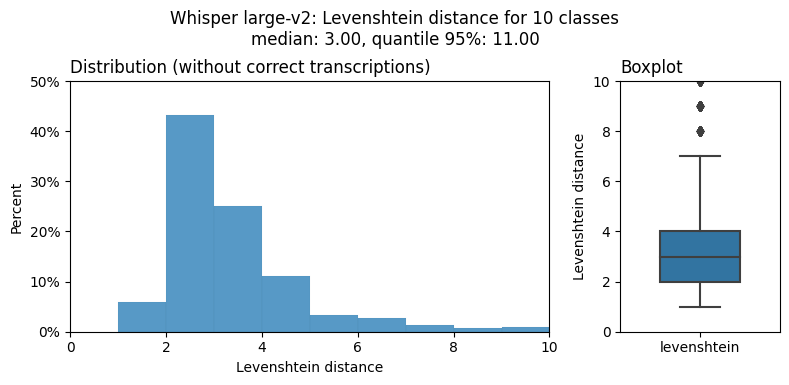

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

f_df = df[df['levenshtein']>0]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]})
sns.histplot(f_df['levenshtein'], kde=False, binwidth=1, ax=ax[0], stat='percent')
ax[0].set_title(f'Distribution (without correct transcriptions)', loc='left')
ax[0].set_xlabel('Levenshtein distance')
ax[0].set_ylabel('Percent')
ax[0].set_xlim(0, 10)
ax[0].set_yticks([y for y in ax[0].get_yticks() if y % 5 == 0])
ax[0].set_yticklabels([f'{int(y)}%' for y in ax[0].get_yticks()])

sns.boxplot(data=pd.DataFrame(f_df['levenshtein']), ax=ax[1], width=0.5)
ax[1].set_title(f'Boxplot', loc='left')
ax[1].set_xlabel('')
ax[1].set_ylabel('Levenshtein distance')
ax[1].set_ylim(0, 10)

fig.suptitle(f'Whisper {model_name_title_addition}: Levenshtein distance for {len(f_df.reference.unique())} classes\nmedian: {np.median(f_df["levenshtein"]):.2f}, quantile 95%: {np.quantile(f_df["levenshtein"], 0.95):.2f}', y=0.95)
fig.tight_layout()
fig.savefig(plots_root + f'levenshtein_distance_{len(f_df["reference"].unique())}_classes.png', dpi=300)
plt.show()


## CER - Character Error Rate

Divide the number of characters that are different by the total number of characters.

In [154]:
# from jiwer import  cer

# df['cer'] = df.apply(lambda x: cer(x['reference'], x['hypothesis']), axis=1)
# df[:3]

In [155]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]})
# sns.histplot(df['cer'], kde=False, binwidth=0.5, ax=ax[0], stat='percent')
# ax[0].set_title(f'Distribution', loc='left')
# ax[0].set_xlabel('CER')
# ax[0].set_ylabel('Percent')
# ax[0].set_xlim(0, 4)
# ax[0].set_yticks([y for y in ax[0].get_yticks() if y % 5 == 0])
# ax[0].set_yticklabels([f'{int(y)}%' for y in ax[0].get_yticks()])

# sns.boxplot(data=pd.DataFrame(df['cer']), ax=ax[1], width=0.5)
# ax[1].set_title(f'Boxplot', loc='left')
# ax[1].set_xlabel('')
# ax[1].set_ylabel('CER')
# ax[1].set_ylim(0, 4)

# fig.suptitle(f'Whisper: Character error rate for {len(df.reference.unique())} classes\nmedian: {np.median(df["cer"]):.2f}, quantile 95%: {np.quantile(df["cer"], 0.95):.2f}', y=0.95)
# fig.tight_layout()
# fig.savefig(plots_root + f'cer_{len(df["reference"].unique())}_classes.png', dpi=300)
# plt.show()

## Accuracy

### Overall accuracy

In [156]:
accuracy = df[df['levenshtein'] == 0].shape[0] / df.shape[0]
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.712


### Per class accuracy

In [157]:
# sort numbers in correct order

# number_in_correct_order = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] + \
#                         ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] + \
#                         [a for a in df.reference.unique() if a not in \
#                     ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] 
#                     and a not in ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']]
# number_in_correct_order = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
number_in_correct_order = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

df['reference'] = pd.Categorical(df['reference'], categories=number_in_correct_order, ordered=True)
df.sort_values(by=['reference'], inplace=True)
df

,hypothesis,reference,levenshtein,cer
23681,yes,yes,0,0.0
22100,yes,yes,0,0.0
22099,yes,yes,0,0.0
22098,yes,yes,0,0.0
22097,yes,yes,0,0.0
...,...,...,...,...
15796,go,go,0,0.0
15795,go,go,0,0.0
15794,bye,go,3,1.5
15810,goal,go,2,1.0


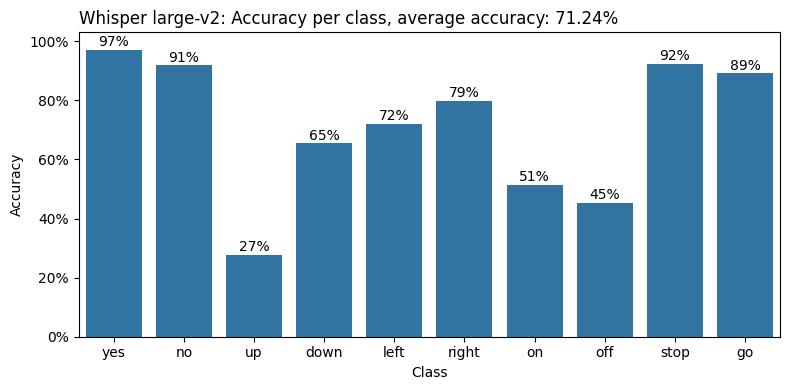

In [158]:
# barlot
import matplotlib.pyplot as plt
import seaborn as sns
import copy

accuracies_per_class = df.groupby('reference').apply(lambda x: x[x['levenshtein'] == 0].shape[0] / x.shape[0])
accuracies_per_class2 = copy.deepcopy(accuracies_per_class)
accuracies_per_class = accuracies_per_class.sort_values(ascending=False)
accuracies_per_class
classes_ordered_by_acc = accuracies_per_class.index

fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x=accuracies_per_class.index, y=accuracies_per_class.values, ax=ax, color='C0')
ax.set_title(f'Whisper {model_name_title_addition}: Accuracy per class, average accuracy: {accuracy:.2%}', loc='left')
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticks([y for y in ax.get_yticks()])
ax.set_yticklabels([f'{int(y * 100)}%' for y in ax.get_yticks()])
ax.set_ylim(0, 1.03)

# # add vertical line after 10 and 20 words
# ax.axvline(x=9.5, color='k', linestyle='-', linewidth=0.5)
# ax.axvline(x=20.5, color='k', linestyle='-', linewidth=0.5)

# # add texts at x=5 and x=15 and y=0.8 and x=25
# ax.text(x=4.5, y=0.9, s='Test words', ha='center', va='center')
# ax.text(x=15.5, y=0.9, s='Numbers', ha='center', va='center')
# ax.text(x=25.5, y=0.9, s='Other words', ha='center', va='center')

for p in ax.patches:
    # ax.annotate(f'{int(p.get_height()*100)}%', (p.get_x() + p.get_width() / 2., p.get_height()-0.1), ha='center', va='center', xytext=(0, 10), textcoords='offset points', rotation=90)
    ax.annotate(f'{int(p.get_height()*100)}%', (p.get_x() + p.get_width() / 2., p.get_height()-0.021), ha='center', va='center', xytext=(0, 10), textcoords='offset points', rotation=0)
fig.tight_layout()
fig.savefig(plots_root + f'accuracy_per_class_{len(df["reference"].unique())}_classes.png', dpi=300)
plt.show()

# Most common errors per class

In [159]:
df_counts = df.groupby('reference').apply(lambda x: x['hypothesis'].value_counts()).reset_index()
df_counts.columns = ['reference', 'hypothesis', 'count']
df_counts.sort_values(by=['reference', 'count'], ascending=[True, False], inplace=True)
df_counts['percentage'] = df_counts['count'] / df_counts.groupby('reference')['count'].transform('sum')
df_counts = df_counts[df_counts['percentage'] >= 0.03]
df_counts = df_counts[df_counts['hypothesis'] != df_counts['reference']]
for class_ in classes_ordered_by_acc:
    if class_ not in df_counts['reference'].values:
        emtpy_df = pd.DataFrame({'reference': [class_], 'hypothesis': [''], 'count': [0], 'percentage': [0]})
        df_counts = pd.concat([df_counts, emtpy_df])
df_counts['reference'] = pd.Categorical(df_counts['reference'], categories=number_in_correct_order, ordered=True)
df_counts.sort_values(by=['reference', 'count'], ascending=[True, False], inplace=True)
df_counts[:5]

,reference,hypothesis,count,percentage
0,yes,,0,0.000000
0,no,,0,0.000000
108,up,oh,677,0.285053
110,up,ah,209,0.088000
111,up,f,154,0.064842


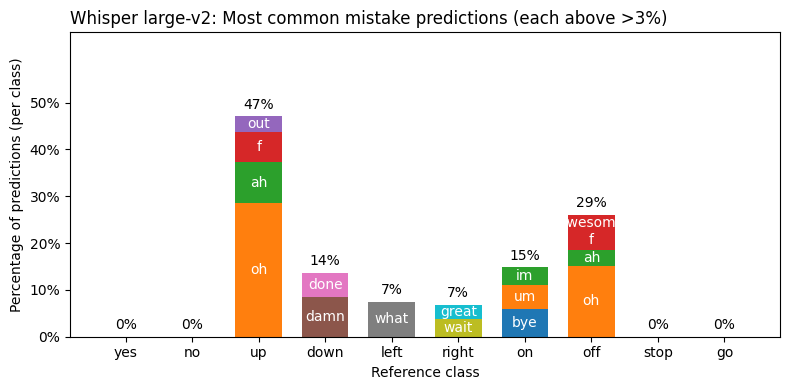

In [161]:
import matplotlib.pyplot as plt
import numpy as np


species = df_counts['reference'].unique()
weight_counts = {}

for h in df_counts['hypothesis'].unique():
    weight_counts[h] = np.array([0.0]*len(accuracies_per_class2))

for i in range(df_counts.shape[0]):
    id = list(accuracies_per_class2.index).index(df_counts['reference'].values[i])
    weight_counts[df_counts['hypothesis'].values[i]][id] = df_counts['percentage'].values[i]
width = 0.7

fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(species))

for label, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=label, bottom=bottom)
    for i, r in enumerate(p):
        if r.get_height() > 0.03:
            ax.text(r.get_x() + r.get_width() / 2., r.get_height() / 2. + bottom[i], f'{label}', ha='center', va='center', color='white', rotation=0)
    bottom += weight_count

for i, r in enumerate(p):
    t = bottom[i]
    if r.get_height() > 0:
        t += r.get_height()
    ax.text(r.get_x() + r.get_width() / 2., 0.025 + bottom[i], f'{t:.0%}', ha='center', va='center', color='black')

ax.set_title(f'Whisper {model_name_title_addition}: Most common mistake predictions (each above >3%)', loc='left')
# ax.set_title(f'Whisper: Most common mistake predictions (each bar is >3%, bar with name >8%)', loc='left')
ax.set_xlabel('Reference class')
ax.set_ylabel('Percentage of predictions (per class)')
ax.set_xticks([x for x in ax.get_xticks()])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticks([y for y in ax.get_yticks()])
ax.set_yticklabels([f'{int(y * 100)}%' for y in ax.get_yticks()])
# ax.set_ylim(0, 0.55)
ax.set_ylim(0, 0.65)

# # add vertical line after 10 and 20 words
# ax.axvline(x=9.5, color='k', linestyle='-', linewidth=0.5)
# ax.axvline(x=20.5, color='k', linestyle='-', linewidth=0.5)

# # add texts at x=5 and x=15 and y=0.8 and x=25
# ax.text(x=4.5, y=0.6, s='Test words', ha='center', va='center')
# ax.text(x=15.5, y=0.6, s='Numbers', ha='center', va='center')
# ax.text(x=25.5, y=0.6, s='Other words', ha='center', va='center')

fig.tight_layout()
fig.savefig(plots_root + f'most_common_mistakes_{len(df["reference"].unique())}_classes.png', dpi=300)

plt.show()

## Confusion matrix

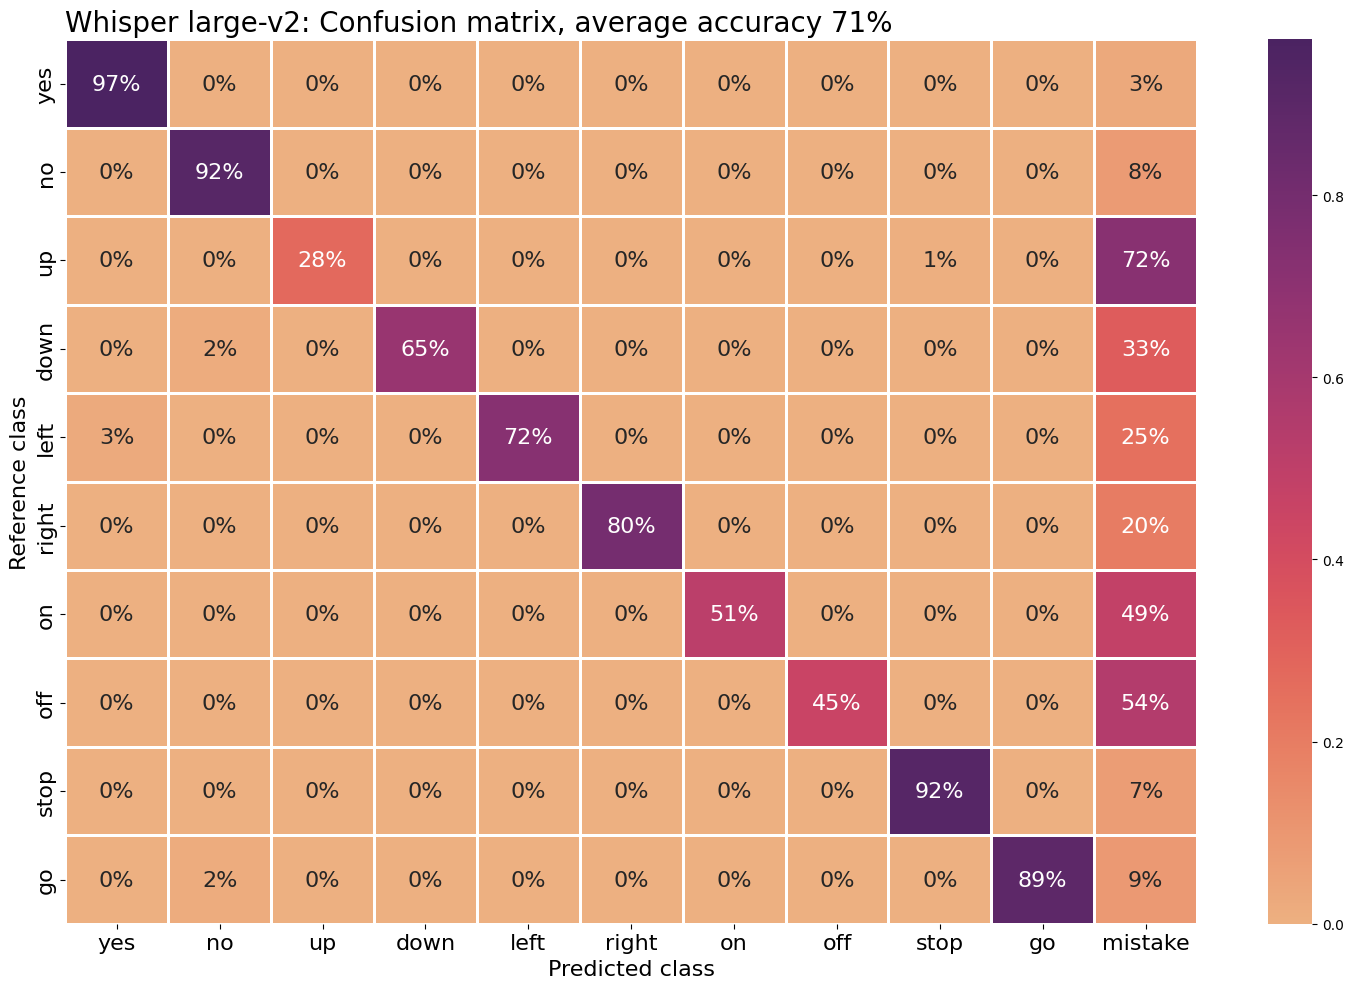

In [162]:

df_cf = df.loc[:, ['reference', 'hypothesis']]
df_cf['hypothesis'] = df_cf.apply(lambda x: x['hypothesis'] if x['hypothesis'] in list(classes_ordered_by_acc) else 'mistake', axis=1)
import seaborn as sns
import matplotlib.pyplot as plt
df_confusion = pd.crosstab(df_cf['reference'], df_cf['hypothesis'])
df_confusion = df_confusion.div(df_confusion.sum(axis=1), axis=0)
df_confusion = df_confusion[number_in_correct_order+ ['mistake']]
df_confusion = df_confusion.reindex(number_in_correct_order)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df_confusion, linewidths=1, annot=True,cmap="flare", ax=ax, fmt='.0%', annot_kws={"size": 16})
plt.title(f"Whisper {model_name_title_addition}: Confusion matrix, average accuracy {accuracy:.0%}", size=20, loc='left')
plt.xlabel('Predicted class', size=16)
plt.ylabel('Reference class', size=16)
# increase font size of labels
ax.tick_params(axis='both', which='major', labelsize=16)

# # add vertical line after 10 and 20 words
# ax.axvline(x=10, color='k', linestyle='-', linewidth=2)
# ax.axvline(x=20, color='k', linestyle='-', linewidth=2)
# # add horizontal line after 10 and 20 words
# ax.axhline(y=10, color='k', linestyle='-', linewidth=2)
# ax.axhline(y=20, color='k', linestyle='-', linewidth=2)


fig.tight_layout()
fig.savefig(plots_root + f'confusion_matrix_{len(df["reference"].unique())}_classes.png', dpi=300)
plt.show()
